# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

# Preprocessing

A function to take the data instances as strings and convert them into a tuple that can be easily manipulated by the model. If matrix_output is True the Q matrix is output as a 2d array (matrix), otherwise it's output as a 1d array

In [2]:
def process_data_value(data_value, matrix_output = True):
    import numpy as np
    
    y = data_value.split('{{', 1)
    a, b = y[0].split('{')[1], y[1].split('}}', 1)
    x = a.split(',')[:-1]
    z = b[1].split(',')[1: -1]
    q = b[0].replace('}', '').replace('{', '').split(',')
    for i in range(len(x)):
        x[i] = int(x[i])
    for i in range(len(z)):
        if i != 1 and z[i] != 'Null':
            z[i] = int(z[i])
    for i in range(len(q)):
        q[i] = int(q[i])
    if x[1] == z[2]: # is manifold favourable
        z.append('True')
    else:
        if z[2] != 'Null':
            z.append('False')
        else:
            z.append('Null')
    if matrix_output:
        q = np.array(q).reshape((x[1], x[2])) 
    else:
        q = np.array(q)       
    return x, q, z

A pair of functions to read in the data instances from the appropriate file and then process them. In the first case all of the information on each instance is retained, with the Q matrix being a 2d array if matrix_output is True and a 1d array otherwise. In the second function only the Q matrix (given as a 2d array if matrix_output = True, or a 1d array otherwise) and a single Hodge number (of the users' choice) are returned as a tuple. 

In [3]:
def load_instances(file_path, matrix_output = True):
    import numpy as np
    instances = []
    
    with open(file_path, 'r') as f:
        line = f.readlines(1)
        while line != []:
            example = process_data_value(line[0], matrix_output)
            instances.append(example)
            line = f.readlines(1)
    return np.array(instances, dtype = object)

In [4]:
def load_X_Y_instances(file_path, X_index, Y_index, matrix_output = True):
    import numpy as np
    X, Y = [], []
    
    with open(file_path, 'r') as f:
        line = f.readlines(1)
        while line != []:
            example = process_data_value(line[0], matrix_output)
            X.append(example[X_index])
            Y.append(example[-1][Y_index])
            line = f.readlines(1)
    return np.array(X, dtype = object), np.array(Y, dtype = np.int32)

A function to load the instances in a given file, pad them and return Q matrices and labels in a form that can directly be used in a model (since the shape of X is of form (number_instances, rows, columns)).

In [5]:
def load_padded_X_Y_instances(file_path, X_index, Y_index, desired_shape, padding = 0, matrix_output = True):
    import numpy as np
    X_prime, Y = [], [] 
    
    with open(file_path, 'r') as f:
        line = f.readlines(1)
        while line != []:
            example = process_data_value(line[0], matrix_output)
            X_prime.append(example[X_index])
            Y.append(example[-1][Y_index])
            line = f.readlines(1)
            
    X = np.full((len(X_prime), desired_shape[0], desired_shape[1]), padding)
    i = 0
    for q_matrix in X_prime:
        X[i, :, :] = pad_q_matrix(desired_shape = desired_shape, q_matrix = q_matrix, padding = 0)
        i += 1
    
    return X, np.array(Y, dtype = np.int32)

A function to pad a Q matrix, given in 2d array form, to a desired shape.

In [6]:
def pad_q_matrix(desired_shape, q_matrix, padding = 0):
    import numpy as np
    m, K = q_matrix.shape[0], q_matrix.shape[1]
    q_tilde = np.full(desired_shape, padding)
    j = 0
    for i in range(m):
        for j in range(K):
            q_tilde[i, j] = q_matrix[i, j]
    return q_tilde

# Train, validation, test data split

Read in the train, validation and test sets from the appropriate files

In [7]:
X_train, Y_train = load_padded_X_Y_instances('./data/CICY_4_train.txt', 1, 2, desired_shape = (16, 20))
X_val, Y_val = load_padded_X_Y_instances('./data/CICY_4_validation.txt', 1, 2, desired_shape = (16, 20))

In [8]:
X_train.shape, Y_train.shape

((135852, 16, 20), (135852,))

In [9]:
X_val.shape, Y_val.shape

((45284, 16, 20), (45284,))

# Model for h<sup>1,1</sup>

In [10]:
classifier_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [16, 20]),
    keras.layers.Dense(units = 512, activation = 'sigmoid'),
    keras.layers.Dropout(rate = 0.4),
    keras.layers.Dense(units = 256, activation = 'sigmoid'),
    keras.layers.Dropout(rate = 0.3),
    keras.layers.Dense(units = 256, activation = 'sigmoid'),
    keras.layers.Dense(units = 24, activation = 'softmax')
])

classifier_model.compile(loss = 'mse', optimizer = keras.optimizers.Adam(learning_rate = 0.001))

In [11]:
history = classifier_model.fit(X_train, Y_train, epochs = 10)

Epoch 1/10
4246/4246 [==============================] - 14s 3ms/step - loss: 106.2179
Epoch 2/10
4246/4246 [==============================] - 12s 3ms/step - loss: 106.2177
Epoch 3/10
4246/4246 [==============================] - 13s 3ms/step - loss: 106.2178
Epoch 4/10
4246/4246 [==============================] - 15s 3ms/step - loss: 106.2179
Epoch 5/10
4246/4246 [==============================] - 13s 3ms/step - loss: 106.2178
Epoch 6/10
4246/4246 [==============================] - 13s 3ms/step - loss: 106.2178
Epoch 7/10
4246/4246 [==============================] - 13s 3ms/step - loss: 106.2177
Epoch 8/10
4246/4246 [==============================] - 13s 3ms/step - loss: 106.2178
Epoch 9/10
4246/4246 [==============================] - 13s 3ms/step - loss: 106.2178
Epoch 10/10
4246/4246 [==============================] - 12s 3ms/step - loss: 106.2178


Issue now obvious, softmax outputs numbers in \[0,1\] whilst the targets are integers from 0 to 24

In [12]:
classifier_model_v2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [16, 20]),
    keras.layers.Dense(units = 512, activation = 'relu'),
    keras.layers.Dropout(rate = 0.4),
    keras.layers.Dense(units = 256, activation = 'relu'),
    keras.layers.Dropout(rate = 0.3),
    keras.layers.Dense(units = 256, activation = 'relu'),
    keras.layers.Dense(units = 25, activation = 'softmax')
])

classifier_model_v2.compile(loss = 'sparse_categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = 1/ 300), metrics = ['accuracy'])

In [13]:
history = classifier_model_v2.fit(X_train, Y_train, epochs = 150,
                                  validation_data = (X_val, Y_val))

Epoch 1/150
4246/4246 [==============================] - 14s 3ms/step - loss: 1.2168 - accuracy: 0.6057 - val_loss: 1.0323 - val_accuracy: 0.6568
Epoch 2/150
4246/4246 [==============================] - 14s 3ms/step - loss: 1.0717 - accuracy: 0.6493 - val_loss: 0.9413 - val_accuracy: 0.6876
Epoch 3/150
4246/4246 [==============================] - 13s 3ms/step - loss: 1.0105 - accuracy: 0.6711 - val_loss: 0.8751 - val_accuracy: 0.7189
Epoch 4/150
4246/4246 [==============================] - 13s 3ms/step - loss: 0.9649 - accuracy: 0.6882 - val_loss: 0.8317 - val_accuracy: 0.7297
Epoch 5/150
4246/4246 [==============================] - 14s 3ms/step - loss: 0.9276 - accuracy: 0.7015 - val_loss: 0.7894 - val_accuracy: 0.7444
Epoch 6/150
4246/4246 [==============================] - 13s 3ms/step - loss: 0.8967 - accuracy: 0.7161 - val_loss: 0.7626 - val_accuracy: 0.7603
Epoch 7/150
4246/4246 [==============================] - 14s 3ms/step - loss: 0.8693 - accuracy: 0.7265 - val_loss: 0.7226 -

Epoch 57/150
4246/4246 [==============================] - 12s 3ms/step - loss: 0.5614 - accuracy: 0.8473 - val_loss: 0.4341 - val_accuracy: 0.8839
Epoch 58/150
4246/4246 [==============================] - 12s 3ms/step - loss: 0.5645 - accuracy: 0.8490 - val_loss: 0.4182 - val_accuracy: 0.8878
Epoch 59/150
4246/4246 [==============================] - 12s 3ms/step - loss: 0.5563 - accuracy: 0.8494 - val_loss: 0.4297 - val_accuracy: 0.8873
Epoch 60/150
4246/4246 [==============================] - 12s 3ms/step - loss: 0.5676 - accuracy: 0.8501 - val_loss: 0.4515 - val_accuracy: 0.8824
Epoch 61/150
4246/4246 [==============================] - 12s 3ms/step - loss: 0.5560 - accuracy: 0.8523 - val_loss: 0.4162 - val_accuracy: 0.8897
Epoch 62/150
4246/4246 [==============================] - 12s 3ms/step - loss: 0.5535 - accuracy: 0.8511 - val_loss: 0.4141 - val_accuracy: 0.8912
Epoch 63/150
4246/4246 [==============================] - 12s 3ms/step - loss: 0.5608 - accuracy: 0.8522 - val_loss: 0

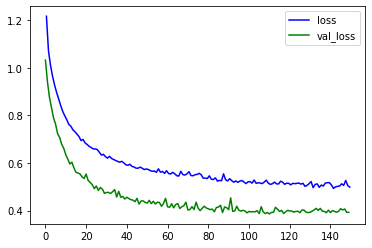

In [18]:
epochs = np.array([i for i in range(150)])
plt.plot(epochs + 1/2, history.history['loss'], label = 'loss', color = 'b')
plt.plot(epochs, history.history['val_loss'], label = 'val_loss', color = 'g')
plt.legend(loc = 'best')
plt.show()

In [19]:
classifier_model_v2.save('512_0.4_256_0.3_256_25_relu_softmax_cross_entropy_adam_model.h5')